In [1]:
import keras as keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model


/home/jorgel/.virtualenvs/dl4cv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# This returns a tensor
inputs = Input(shape=(784,))

In [3]:
inputs

<tf.Tensor 'input_1:0' shape=(?, 784) dtype=float32>

In [4]:
# a layer instance is callable on a tensor, and returns a tensor
x = Dense(64, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

In [5]:
# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [6]:
plot_model(model)

In [7]:
x = Input(shape=(784,))
# This works, and returns the 10-way softmax we defined above.
y = model(x)

In [8]:
y

<tf.Tensor 'model_1/dense_3/Softmax:0' shape=(?, 10) dtype=float32>

In [9]:
from keras.layers import TimeDistributed

# Input tensor for sequences of 20 timesteps,
# each containing a 784-dimensional vector
input_sequences = Input(shape=(20, 784))

# This applies our previous model to every timestep in the input sequences.
# the output of the previous model was a 10-way softmax,
# so the output of the layer below will be a sequence of 20 vectors of size 10.
processed_sequences = TimeDistributed(model)(input_sequences)

In [10]:
processed_sequences

<tf.Tensor 'time_distributed_1/Reshape_1:0' shape=(?, 20, 10) dtype=float32>

In [11]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

# Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
# Note that we can name any layer by passing it a "name" argument.
main_input = Input(shape=(100,), dtype='int32', name='main_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
x = Embedding(output_dim=512, input_dim=10000, input_length=100)(main_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32)(x)

In [12]:
#Here we insert the auxiliary loss, allowing the LSTM and Embedding 
#layer to be trained smoothly even though the main loss will be much higher in the model.

auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(lstm_out)

In [13]:
#At this point, we feed into the model our auxiliary input data by 
#concatenating it with the LSTM output:

auxiliary_input = Input(shape=(5,), name='aux_input')
x = keras.layers.concatenate([lstm_out, auxiliary_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(1, activation='sigmoid', name='main_output')(x)

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32

visible = Input(shape=IMAGE_DIMS)
conv1 = Conv2D(64, kernel_size=4, activation='relu')(visible)
pool1 = AveragePooling2D(pool_size=(2, 2))(conv1)
drop1 = Dropout(0.25)(pool1)
conv2 = Conv2D(32, kernel_size=4, activation='relu')(pool1)
pool2 = AveragePooling2D(pool_size=(2, 2))(conv2)
drop2 = Dropout(0.25)(pool2)
conv3 = Conv2D(16, kernel_size=4, activation='relu')(pool2)
pool3 = AveragePooling2D(pool_size=(2, 2))(conv3)
drop3 = Dropout(0.25)(pool3)
flat = Flatten()(pool3)
#hidden1 = Dense(10, activation='relu')(flat)
output = Dense(7, activation='sigmoid')(flat)
model = Model(inputs=visible, outputs=output)
# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file='convolutional_neural_network.png')

In [33]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.models import model_from_json
from keras.layers.pooling import AveragePooling2D
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os


In [34]:
IMAGE_DIMS = (64, 64, 3)
# initialize the data and labels
data = []
labels = []
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Convolutional Neural Network
# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
path = '/home/jorgel/Documents/faceRec/dataset'
imagePaths = sorted(list(paths.list_images(path)))
print(len(imagePaths))
random.seed(42)
random.shuffle(imagePaths)

[INFO] loading images...
1610


In [38]:
# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    face = face_cascade.detectMultiScale(image, 1.1, 7)
    x = face[0][0]
    y = face[0][1]
    w = face[0][2]
    h = face[0][3]
    #print(x,y,h,w)
    crop_img = image[y:y+h, x:x+w]
    img = cv2.resize(crop_img, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    #img = img_to_array(img)    
    data.append(img)
 
    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

data = np.array(data, dtype="float") / 255
# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
    


In [39]:
print(data[:10])
print(data.shape)
print("labels {}".format(labels))

[[[[0.29411765 0.34509804 0.40784314]
   [0.30980392 0.37647059 0.43921569]
   [0.18823529 0.27058824 0.32941176]
   ...
   [0.30196078 0.34509804 0.4       ]
   [0.25490196 0.31764706 0.38039216]
   [0.25882353 0.35686275 0.42352941]]

  [[0.23529412 0.28627451 0.35686275]
   [0.26666667 0.32941176 0.4       ]
   [0.21568627 0.29019608 0.36078431]
   ...
   [0.2627451  0.34117647 0.39607843]
   [0.29019608 0.36470588 0.42352941]
   [0.31764706 0.37647059 0.44705882]]

  [[0.24705882 0.28235294 0.34509804]
   [0.26666667 0.3254902  0.37647059]
   [0.16078431 0.20784314 0.27843137]
   ...
   [0.23529412 0.3254902  0.38823529]
   [0.29803922 0.34901961 0.42352941]
   [0.19607843 0.27843137 0.34509804]]

  ...

  [[0.74117647 0.74901961 0.75294118]
   [0.72941176 0.7372549  0.74117647]
   [0.73333333 0.74117647 0.74509804]
   ...
   [0.68235294 0.69019608 0.69019608]
   [0.68235294 0.69019608 0.69019608]
   [0.69411765 0.70196078 0.70196078]]

  [[0.74117647 0.7372549  0.74509804]
   [0.7

In [40]:
print(labels[0:10])
print(labels.shape)
print("Labels {}".format(labels))

[[0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0]]
(2106, 7)
Labels [[0 0 0 ... 0 1 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


In [41]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,labels,test_size=0.3,random_state=42)

In [42]:
print("Size {}".format(len(labels)))
print(labels.shape)
print(trainX.shape, testX.shape)
print(trainY.shape, testY.shape)

Size 2106
(2106, 7)
(1474, 64, 64, 3) (632, 64, 64, 3)
(1474, 7) (632, 7)


In [43]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

def build(width, height, depth, classes):
	# initialize the model along with the input shape to be
	# "channels last" and the channels dimension itself
	model = Sequential()
	inputShape = (height, width, depth)
	chanDim = -1
 
	# if we are using "channels first", update the input shape
	# and channels dimension
	if K.image_data_format() == "channels_first":
		inputShape = (depth, height, width)
		chanDim = 1
	# CONV => RELU => POOL
	model.add(Conv2D(32, (3, 3), padding="same",
		input_shape=inputShape))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(3, 3)))
	model.add(Dropout(0.25))
	# (CONV => RELU) * 2 => POOL
	model.add(Conv2D(64, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(64, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))
	# (CONV => RELU) * 2 => POOL
	model.add(Conv2D(128, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(128, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))
	# first (and only) set of FC => RELU layers
	model.add(Flatten())
	model.add(Dense(1024))
	model.add(Activation("relu"))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
 
	# softmax classifier
	model.add(Dense(classes))
	model.add(Activation("softmax"))
 
	# return the constructed network architecture
	return model 





In [44]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 32


print("[INFO] compiling model...")
model = build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
	depth=IMAGE_DIMS[2], classes=7)

[INFO] compiling model...


In [45]:
# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file='VGG16.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 21, 21, 64)        0         
__________

In [46]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [47]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

In [48]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

[INFO] training network...
Epoch 1/100
46/46 [==============================] - 31s 682ms/step - loss: 3.0365 - acc: 0.1930 - val_loss: 2.5421 - val_acc: 0.2373
Epoch 2/100
46/46 [==============================] - 31s 676ms/step - loss: 2.3939 - acc: 0.2569 - val_loss: 1.7684 - val_acc: 0.4098
Epoch 3/100
46/46 [==============================] - 30s 644ms/step - loss: 2.2324 - acc: 0.2936 - val_loss: 6.0348 - val_acc: 0.1962
Epoch 4/100
46/46 [==============================] - 30s 661ms/step - loss: 2.0273 - acc: 0.3539 - val_loss: 2.5304 - val_acc: 0.2848
Epoch 5/100
46/46 [==============================] - 30s 658ms/step - loss: 2.1165 - acc: 0.3234 - val_loss: 1.7179 - val_acc: 0.4557
Epoch 6/100
46/46 [==============================] - 29s 640ms/step - loss: 1.9303 - acc: 0.3506 - val_loss: 2.0915 - val_acc: 0.4589
Epoch 7/100
46/46 [==============================] - 30s 650ms/step - loss: 1.8447 - acc: 0.3684 - val_loss: 1.3937 - val_acc: 0.4937
Epoch 8/100
46/46 [================

46/46 [==============================] - 30s 643ms/step - loss: 1.1729 - acc: 0.5627 - val_loss: 1.9204 - val_acc: 0.3038
Epoch 61/100
46/46 [==============================] - 30s 651ms/step - loss: 1.1977 - acc: 0.5435 - val_loss: 2.1620 - val_acc: 0.4114
Epoch 62/100
46/46 [==============================] - 31s 667ms/step - loss: 1.1608 - acc: 0.5673 - val_loss: 2.3663 - val_acc: 0.2389
Epoch 63/100
46/46 [==============================] - 30s 652ms/step - loss: 1.0859 - acc: 0.5774 - val_loss: 1.3162 - val_acc: 0.5237
Epoch 64/100
46/46 [==============================] - 29s 636ms/step - loss: 1.2464 - acc: 0.5286 - val_loss: 1.5944 - val_acc: 0.3956
Epoch 65/100
46/46 [==============================] - 30s 650ms/step - loss: 1.1545 - acc: 0.5659 - val_loss: 1.2163 - val_acc: 0.5396
Epoch 66/100
46/46 [==============================] - 31s 664ms/step - loss: 1.2316 - acc: 0.5376 - val_loss: 1.5172 - val_acc: 0.5016
Epoch 67/100
46/46 [==============================] - 29s 641ms/step

/home/jorgel/.virtualenvs/dl4cv/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jorgel/.virtualenvs/dl4cv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jorgel/.virtualenvs/dl4cv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jorgel/.virtualenvs/dl4cv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
 

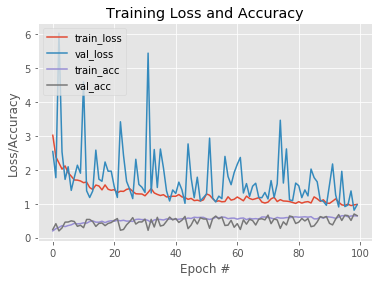

In [49]:
import matplotlib
matplotlib.use("Agg")
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig("EmoTrain_2.png")
plt.show()

In [50]:
scores = model.evaluate(trainX, trainY, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 70.69%
